ffmpeg -f rawvideo -pix_fmt yuv420p -s:v 1920x1080 -r 25 -i input.yuv \
-c:v libx264 output.mp4

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.append('../')

In [25]:
import warnings

In [3]:
import numpy as np

In [4]:
import utils
from make_sample import read_scene

In [5]:
import subprocess

In [6]:
from pathlib import Path

In [7]:
from tqdm import tqdm

In [8]:
import satpy

In [9]:
ffmpeg = '/data/cphillips/miniconda3/envs/ffmpeg/bin/ffmpeg'

In [10]:
L1B_DIR = Path('../l1b/')
L1B_CACHE_DIR = Path('../l1b_cache')

In [11]:
files = sorted(L1B_DIR.glob('2020/202007/*/*/g17/temp_11_00um/*'))

In [13]:
len(files)

1487

In [14]:
reader = utils._readers['g']

In [15]:
def convert_to_uint8(v, vmin=180,vmax=320, fill_uint8=16):
    mask = np.isnan(v)
    # restricted range 16–235
    v = (v-vmin)*220/(vmax-vmin)
    v += 16
    v = v.clip(16,235).astype(np.uint8)
    v[mask] = fill_uint8
    return v

In [16]:
yuv = np.full((5424,5424,3), 128, dtype=np.uint8)

In [17]:
# with tqdm(files[:60]) as bar:
#     with open('input.gray','wb') as fp:
#         for f in bar:
#             v, area = read_scene([f], reader)
#             v = v.values
            
#             assert v.shape == (5424,5424)
#             d = convert_to_uint8(v)
#             fp.write(d.tobytes())

In [18]:
# d = np.memmap('input.gray',dtype=np.uint8).reshape((-1,5424,5424,1))

In [19]:
# !/data/cphillips/ffmpeg/ffmpeg-4.4-amd64-static/ffmpeg -y -f rawvideo -pix_fmt gray -s:v 5424x5424 -r 8 -i input.gray -c:v libx264 -preset slow -qp 30 -b:v 10M -tune psnr output.mp4

In [20]:
# !/data/cphillips/ffmpeg/ffmpeg-4.4-amd64-static/ffmpeg -y -f rawvideo -pix_fmt gray -s:v 5424x5424 -r 8 -i input.gray -c:v libx265 -preset medium -x265-params 'qp=30:deblock=2:sao=false:strong-intra-smoothing=false' -b:v 1G -tune psnr output.mp4

In [21]:
# !/data/cphillips/ffmpeg/ffmpeg-4.4-amd64-static/ffmpeg -y -i output.mp4 -f rawvideo -pix_fmt gray roundtrip.gray 

In [ ]:
p = subprocess.Popen([
    '/data/cphillips/ffmpeg/ffmpeg-4.4-amd64-static/ffmpeg',
#     '-y',
 '-f',
 'rawvideo',
 '-pix_fmt',
 'gray',
 '-s:v',
 '5424x5424',
 '-r',
 '8',
 '-i',
 '-',
 '-c:v',
 'libx265',
 '-preset','medium', '-x265-params',
    'qp=30:deblock=2:sao=false:strong-intra-smoothing=false',
    '-b:v', '1G', '-tune', 'psnr', '../l1b_cache/2020/202007/temp_11_00um_g17.mp4'], stdin=subprocess.PIPE)
with tqdm(files[:]) as bar:
    for f in bar:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            v, area = read_scene([f], reader)
            v = v.values
            assert v.shape == (5424,5424)
            d = convert_to_uint8(v)
            p.stdin.write(d.tobytes())
p.stdin.close()
p.wait()

 61%|██████    | 900/1487 [26:50<18:00,  1.84s/it]

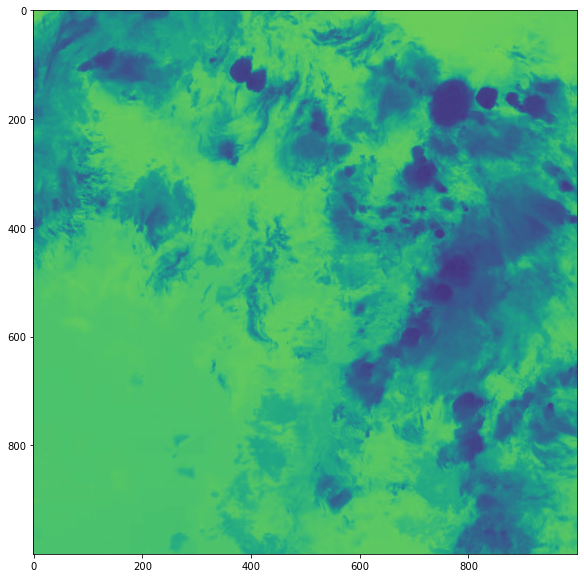

In [121]:
figure(figsize=(10,10))
imshow(r[50][2000:3000,2000:3000,0], vmin=0, vmax=255)

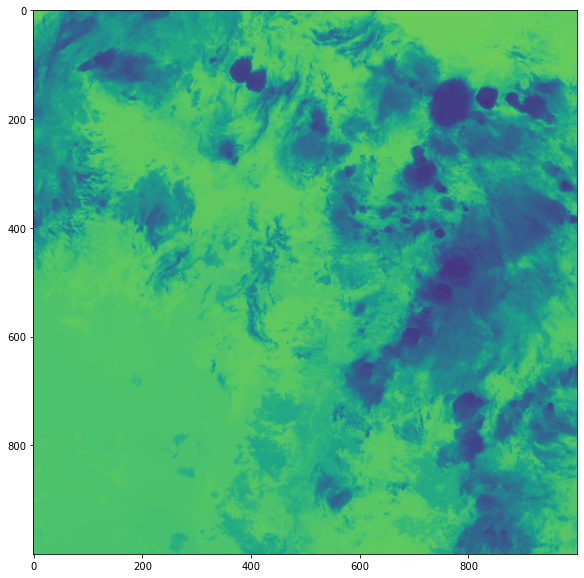

In [109]:
figure(figsize=(10,10))
imshow(d[50][2000:3000,2000:3000,0], vmin=0, vmax=255)